In [ ]:
# ----------------------------
# Step 1: Load expression, clinical data, and DEGs
# ----------------------------
import pandas as pd

# Load expression counts
expr_file = "/content/Survival_Expression_RawCounts_TNBC_vs_Other.csv"
expr = pd.read_csv(expr_file, index_col=0)
print("Expression matrix shape (genes x samples):", expr.shape)

# Load clinical data
clinical_file = "/content/Survival_Clinical_TNBC_vs_Other.csv"
clinical = pd.read_csv(clinical_file)
print("Clinical data shape (rows x columns):", clinical.shape)

# Load DEG list
deg_file = "/content/DESeq2_TNBC_vs_Other_full_results.csv"
deg = pd.read_csv(deg_file)
print("DEG columns:", deg.columns)
print("Number of DEGs:", deg.shape[0])


Expression matrix shape (genes x samples): (5000, 852)
Clinical data shape (rows x columns): (852, 124)
DEG columns: Index(['baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj',
       'gene_symbol', 'Ensembl_ID'],
      dtype='object')
Number of DEGs: 5000


In [ ]:
# ----------------------------
# Step 2a: Inspect survival-related columns
# ----------------------------
survival_cols = ['death_days_to', 'last_contact_days_to', 'is_deceased']

print("Survival-related columns preview:")
print(clinical[survival_cols].head())

for col in survival_cols:
    missing = clinical[col].isna().sum()
    print(f"Missing values in '{col}': {missing}")

print("\nUnique values in 'is_deceased':", clinical['is_deceased'].unique())


Survival-related columns preview:
      death_days_to last_contact_days_to  is_deceased
0  [Not Applicable]                 3767            0
1  [Not Applicable]                 3801            0
2  [Not Applicable]                 1217            0
3  [Not Applicable]                 1477            0
4  [Not Applicable]                  437            0
Missing values in 'death_days_to': 0
Missing values in 'last_contact_days_to': 0
Missing values in 'is_deceased': 0

Unique values in 'is_deceased': [0 1]


In [ ]:
# ----------------------------
# Step 2b: Create unified survival time and event columns
# ----------------------------

# Event: use the clean binary column already present
clinical['event'] = clinical['is_deceased'].astype(int)

# Survival time: death_days_to if deceased, otherwise last_contact_days_to
clinical['survival_time'] = clinical.apply(
    lambda row: row['death_days_to'] if row['event'] == 1 else row['last_contact_days_to'],
    axis=1
)


In [ ]:
# ----------------------------
# Step 2C: Extract only necessary survival columns
# ----------------------------

clinical['patient_id'] = clinical['bcr_patient_barcode'].str[:12]

survival_df = clinical[['patient_id', 'survival_time', 'event', 'tnbc_status']].copy()

print("Survival dataframe shape:", survival_df.shape)
print(survival_df.head())


Survival dataframe shape: (852, 4)
     patient_id survival_time  event tnbc_status
0  TCGA-3C-AAAU          3767      0    Non-TNBC
1  TCGA-3C-AALI          3801      0    Non-TNBC
2  TCGA-3C-AALK          1217      0    Non-TNBC
3  TCGA-5L-AAT0          1477      0    Non-TNBC
4  TCGA-A1-A0SD           437      0    Non-TNBC


In [ ]:
# ----------------------------
# Step 3: Align expression and survival data (correct barcode format)
# ----------------------------

# Convert expression column names: dots → hyphens
expr_fixed = expr.copy()
expr_fixed.columns = expr_fixed.columns.str.replace('.', '-', regex=False)

# Extract 12-character patient IDs from fixed columns
expr_patient_ids = expr_fixed.columns.str[:12]

# Identify overlapping patients
overlap_patients = set(expr_patient_ids).intersection(set(survival_df['patient_id']))
print("Number of overlapping patients:", len(overlap_patients))

# Filter survival data to overlapping patients
surv_final = survival_df[survival_df['patient_id'].isin(overlap_patients)].copy()
surv_final.set_index('patient_id', inplace=True)

# Filter expression matrix to overlap patients
expr_final = expr_fixed.loc[:, expr_patient_ids.isin(overlap_patients)].copy()

# Rename columns to patient IDs and order to match clinical
expr_final.columns = expr_final.columns.str[:12]
expr_final = expr_final.loc[:, surv_final.index]

print("Expression matrix shape:", expr_final.shape)
print("Survival table shape:", surv_final.shape)


Number of overlapping patients: 852
Expression matrix shape: (5000, 852)
Survival table shape: (852, 3)


In [ ]:
# ----------------------------
# Step 3c: Compare patient counts across datasets
# ----------------------------

# Patient sets
clinical_patients = set(clinical['patient_id'])              # all patients in clinical file
survival_patients = set(surv_final.index)                    # patients used in survival models
expression_patients = set(expr_final.columns)                # patients in aligned expression data

# Summary counts
print("Total patients in clinical data:", len(clinical_patients))
print("Patients with survival data:", len(survival_patients))
print("Patients with expression data:", len(expression_patients))
print("Patients in final aligned dataset (common):", len(survival_patients))

# See if any patients were dropped
print("\nDropped from clinical → survival:", clinical_patients - survival_patients)
print("Dropped from survival → expression:", survival_patients - expression_patients)


Total patients in clinical data: 852
Patients with survival data: 852
Patients with expression data: 852
Patients in final aligned dataset (common): 852

Dropped from clinical → survival: set()
Dropped from survival → expression: set()


In [ ]:
# ----------------------------
# Step 4: Subset expression matrix to DEGs using Ensembl IDs
# ----------------------------

# Standardize expression gene row names (remove version numbers)
expr_final.index = expr_final.index.str.split('.').str[0]

# Standardize DEG Ensembl IDs
deg_ids = deg['Ensembl_ID'].str.split('.').str[0].tolist()

# Subset expression to DEGs that overlap
expr_deg = expr_final.loc[expr_final.index.intersection(deg_ids)].copy()

print("Expression shape after subsetting to DEGs:", expr_deg.shape)
print("First 5 DEG genes:", expr_deg.index.tolist()[:5])


Expression shape after subsetting to DEGs: (5000, 852)
First 5 DEG genes: ['ENSG00000153002', 'ENSG00000210082', 'ENSG00000211896', 'ENSG00000198804', 'ENSG00000108821']


In [ ]:
# ----------------------------
# Step 5: Merge DEGs expression with survival data
# ----------------------------

# Transpose expression so patients are rows
expr_deg_T = expr_deg.T  # shape: patients × genes

# Align with survival data using patient_id index
common_patients = expr_deg_T.index.intersection(surv_final.index)

expr_deg_T_aligned = expr_deg_T.loc[common_patients]
surv_aligned = surv_final.loc[common_patients]

# Merge into one modeling dataset
cox_data_deg = pd.concat(
    [surv_aligned[['survival_time', 'event']], expr_deg_T_aligned],
    axis=1
)

print("Cox dataset shape (patients × [survival + DEGs]):", cox_data_deg.shape)
cox_data_deg.head()


Cox dataset shape (patients × [survival + DEGs]): (852, 5002)


,survival_time,event,ENSG00000153002,ENSG00000210082,ENSG00000211896,ENSG00000198804,ENSG00000108821,ENSG00000198886,ENSG00000115414,ENSG00000164692,...,ENSG00000090905,ENSG00000170369,ENSG00000171444,ENSG00000082512,ENSG00000158526,ENSG00000124243,ENSG00000126464,ENSG00000105058,ENSG00000160113,ENSG00000204619
patient_id,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AAAU,3767,0,222179,256837,52511,675231,170142,437203,137676,110463,...,4678,355,867,1487,4230,4440,8771,3725,4682,4073
TCGA-3C-AALI,3801,0,49,132276,254139,366230,347225,284290,201191,199850,...,2785,3,285,1441,4029,4082,4410,2856,2618,3359
TCGA-3C-AALK,1217,0,312,227728,287578,539992,1104141,463880,336918,626179,...,3090,44,1740,1593,2821,1123,4505,4371,3314,3848
TCGA-5L-AAT0,1477,0,429,237665,14842,316058,442529,212981,194163,292992,...,2130,822,1260,1294,2415,763,2659,3798,2351,2922
TCGA-A1-A0SD,437,0,1287010,351031,78038,764375,343797,334880,406770,284174,...,4319,2082,2378,3745,4186,2669,4191,4905,5421,5683


In [ ]:
# ----------------------------
# Step 6: Map Ensembl IDs to Gene Symbols
# ----------------------------
!pip install mygene
import mygene

mg = mygene.MyGeneInfo()

# Use already-clean Ensembl IDs
deg_ids_clean = expr_deg.index.tolist()

print("Querying MyGeneInfo...")
gene_info = mg.querymany(
    deg_ids_clean,
    scopes='ensembl.gene',
    fields='symbol',
    species='human'
)

# Build mapping dictionary: Ensembl → Symbol (fallback to Ensembl if no symbol found)
ensembl_to_symbol = {
    item['query']: item.get('symbol', item['query'])
    for item in gene_info
}

# Apply mapping
expr_deg_mapped = expr_deg.copy()
expr_deg_mapped.index = [ensembl_to_symbol[gene] for gene in expr_deg.index]

# Collapse duplicate gene symbols by averaging their expression
expr_deg_mapped = expr_deg_mapped.groupby(expr_deg_mapped.index).mean()

print("Expression matrix after mapping to gene symbols:")
print(expr_deg_mapped.head())
print("Shape:", expr_deg_mapped.shape)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 1.9 MB/s eta 0:00:00


INFO:biothings.client:querying 1-1000 ...


Querying MyGeneInfo...


INFO:biothings.client:querying 1001-2000 ...
INFO:biothings.client:querying 2001-3000 ...
INFO:biothings.client:querying 3001-4000 ...
INFO:biothings.client:querying 4001-5000 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


Expression matrix after mapping to gene symbols:
patient_id  TCGA-3C-AAAU  TCGA-3C-AALI  TCGA-3C-AALK  TCGA-5L-AAT0  \
A2M              16370.0       13439.0       25401.0       19582.0   
A2ML1               26.0          19.0           9.0          11.0   
AACS              3446.0        1683.0        2244.0        1526.0   
AAGAB             4048.0        6997.0        4399.0        3438.0   
AAMP              6415.0        5937.0        7185.0        6565.0   

patient_id  TCGA-A1-A0SD  TCGA-A1-A0SE  TCGA-A1-A0SF  TCGA-A1-A0SG  \
A2M              71500.0       48276.0       36660.0       34675.0   
A2ML1               51.0           8.0          33.0          20.0   
AACS              2612.0        2752.0        1139.0        5248.0   
AAGAB             6342.0        5352.0        2562.0        7993.0   
AAMP              7881.0        9557.0        7702.0        9829.0   

patient_id  TCGA-A1-A0SI  TCGA-A1-A0SJ  ...  TCGA-S3-AA17  TCGA-UL-AAZ6  \
A2M              33564.0       600

In [ ]:
# ----------------------------
# Step 7: Ensure expression matrix is numeric
# ----------------------------
expr_deg_mapped = expr_deg_mapped.apply(pd.to_numeric, errors='coerce')

nan_counts = expr_deg_mapped.isna().sum().sum()
print(f"Total NaN values in expression matrix: {nan_counts}")


Total NaN values in expression matrix: 0


In [ ]:
# ----------------------------
# Step 8: Log2-transform expression counts
# ----------------------------
import numpy as np

expr_deg_log2 = np.log2(expr_deg_mapped + 1)

print("Expression matrix after log2-transform:")
print(expr_deg_log2.head())
print("Shape:", expr_deg_log2.shape)


Expression matrix after log2-transform:
patient_id  TCGA-3C-AAAU  TCGA-3C-AALI  TCGA-3C-AALK  TCGA-5L-AAT0  \
A2M            13.998855     13.714246     14.632654     14.257314   
A2ML1           4.754888      4.321928      3.321928      3.584963   
AACS           11.751126     10.717676     11.132500     10.576484   
AAGAB          11.983350     12.772727     12.103288     11.747773   
AAMP           12.647458     12.535761     12.810973     12.680799   

patient_id  TCGA-A1-A0SD  TCGA-A1-A0SE  TCGA-A1-A0SF  TCGA-A1-A0SG  \
A2M            16.125676     15.559048     15.161959     15.081650   
A2ML1           5.700440      3.169925      5.087463      4.392317   
AACS           11.351491     11.426789     10.154818     12.357827   
AAGAB          12.630950     12.386132     11.323618     12.964702   
AAMP           12.944346     13.222493     12.911205     13.262976   

patient_id  TCGA-A1-A0SI  TCGA-A1-A0SJ  ...  TCGA-S3-AA17  TCGA-UL-AAZ6  \
A2M            15.034670     15.872867  ...

In [ ]:
# ----------------------------
# Step 9: Create Cox dataset
# ----------------------------

# Transpose so patients are rows
expr_deg_log2_T = expr_deg_log2.T  # shape: patients × genes

# Align patients with survival dataframe
common_patients = expr_deg_log2_T.index.intersection(surv_final.index)

cox_data_deg = pd.concat(
    [
        surv_final.loc[common_patients][['survival_time', 'event']],
        expr_deg_log2_T.loc[common_patients]
    ],
    axis=1
)

print("Cox dataset shape:", cox_data_deg.shape)
cox_data_deg.head()


Cox dataset shape: (852, 5002)


,survival_time,event,A2M,A2ML1,AACS,AAGAB,AAMP,AAR2,AARD,AARS1,...,ZNF706,ZNF91,ZNF92,ZNFX1,ZNHIT1,ZNRF3,ZWINT,ZYX,ZZEF1,ZZZ3
patient_id,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AAAU,3767,0,13.998855,4.754888,11.751126,11.983350,12.647458,12.307770,14.113335,13.756452,...,12.012275,11.744834,12.412834,12.495106,11.615630,11.185495,11.513728,13.201052,12.507795,12.061709
TCGA-3C-AALI,3801,0,13.714246,4.321928,10.717676,12.772727,12.535761,11.774787,7.918863,13.173989,...,11.169299,7.022368,9.159871,12.223398,12.092096,9.594325,10.926296,13.157347,11.347068,9.847057
TCGA-3C-AALK,1217,0,14.632654,3.321928,11.132500,12.103288,12.810973,11.435149,9.756556,12.447083,...,11.384244,11.051209,10.793603,11.803728,11.879966,9.754888,10.774787,13.587426,11.005625,11.074810
TCGA-5L-AAT0,1477,0,14.257314,3.584963,10.576484,11.747773,12.680799,11.204571,9.802516,11.877284,...,10.818582,10.632086,10.985842,11.422065,11.385323,8.900867,9.659996,12.629584,10.703038,11.122828
TCGA-A1-A0SD,437,0,16.125676,5.700440,11.351491,12.630950,12.944346,12.469642,11.822571,12.826946,...,12.474973,11.647009,10.344296,13.679040,11.616549,10.548822,11.108524,13.254586,12.014020,12.055960


In [ ]:
# ----------------------------
# Step 10: Fit penalized CoxPH with subset DEGs
# ----------------------------

!pip install lifelines

from lifelines import CoxPHFitter

# Initialize CoxPHFitter with L2 penalization (ridge)
cox_penalized = CoxPHFitter(penalizer=0.1)  # Adjust penalizer if needed

# Fit model using correct survival column name
cox_penalized.fit(
    cox_data_deg,
    duration_col='survival_time',
    event_col='event',
    show_progress=True
)

# Summary of top coefficients
print("Top coefficients from penalized CoxPH:")
print(cox_penalized.summary.sort_values(by='coef', ascending=False).head(10))


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 9.8 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=da105025b57a9b236c01557e6b214cd0550ed00846ee07a06cad9520ce738d4b
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma
Iteration 1: norm_delta = 1.67e+00, step_size = 0.9500, log_lik = -326.56224, newton_decrement = 2.45e+02, seconds_since_start = 103.3
Iteration 2: norm_delta = 3.09e+00, step_size = 0.9500, log_lik = -360.18837, newton_decrement = 6.44e+02, seconds_since_start = 224.3
Iteration 3: norm_delta = 1.25e+01, step_size = 0.9500, log_lik = -1436.65960, newton_decrement = 9.47e+03, seconds_since_start = 331.9
Iteration 4: norm_delta = 5.22e+01, step_size = 0.2327, log_lik = -4157.81393, newton_d

/usr/local/lib/python3.12/dist-packages/lifelines/utils/__init__.py:990: ConvergenceWarning: Your dataset has more variables than samples. Even with a penalizer (which you must use), convergence is not guaranteed.

  warnings.warn(warning_text, ConvergenceWarning)
/usr/local/lib/python3.12/dist-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


Top coefficients from penalized CoxPH:
               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
TEX261     0.193855   1.213921  0.181465       -0.161809        0.549520   
ID2        0.160705   1.174338  0.131589       -0.097205        0.418614   
LMF2       0.141896   1.152456  0.153888       -0.159719        0.443511   
YWHAB      0.140911   1.151323  0.161444       -0.175514        0.457337   
SRP14      0.139904   1.150164  0.185052       -0.222791        0.502599   
EIF6       0.137628   1.147549  0.158506       -0.173038        0.448295   
ENTPD6     0.136464   1.146213  0.144752       -0.147244        0.420172   
SUMF2      0.129065   1.137764  0.143529       -0.152247        0.410376   
SLC35A4    0.127865   1.136399  0.189153       -0.242868        0.498597   
ERGIC3     0.127660   1.136166  0.168375       -0.202349        0.457668   

           exp(coef) lower 95%  exp(coef) upper 

In [ ]:
# ----------------------------
# Step 11: Evaluate penalized Cox model (Top 20 DEGs)
# ----------------------------

# 1. Top 20 DEGs increasing risk (highest coefficients)
top_risk_DEGs = cox_penalized.summary.sort_values(by='coef', ascending=False).head(20)
print("Top 20 DEGs associated with higher hazard:")
print(top_risk_DEGs[['coef', 'p']])

# 2. Top 20 DEGs decreasing risk (lowest coefficients)
top_protective_DEGs = cox_penalized.summary.sort_values(by='coef', ascending=True).head(20)
print("Top 20 DEGs associated with lower hazard:")
print(top_protective_DEGs[['coef', 'p']])

# 3. Concordance index (model performance)
c_index = cox_penalized.concordance_index_
print(f"Concordance index (C-index) of penalized Cox model: {c_index:.3f}")


Top 20 DEGs associated with higher hazard:
               coef         p
covariate                    
TFPI       0.245408  0.257664
FAM83H     0.239622  0.271472
CAVIN1     0.226096  0.333804
SLC52A2    0.218200  0.373679
PLA2R1     0.211892  0.282799
AGPAT2     0.211000  0.342010
HSDL2      0.209708  0.459720
GFUS       0.205681  0.440811
SNRPB      0.192011  0.536492
CLMP       0.191373  0.363991
GAPDH      0.179823  0.494813
ROBO4      0.178809  0.490187
PKP3       0.176904  0.299882
SLC25A22   0.175443  0.430741
TUBA1C     0.173197  0.537322
KLF4       0.170894  0.360423
PNPLA2     0.170831  0.513269
DCAF13     0.163846  0.554331
S100A11    0.163225  0.464732
ST14       0.162255  0.418925
Top 20 DEGs associated with lower hazard:
                     coef         p
covariate                          
LMOD2           -0.244464  0.232245
PODXL2          -0.206024  0.286368
PSPH            -0.189416  0.406885
ENSG00000281383 -0.182284  0.229768
NUP210          -0.178857  0.291685
SLC

Top risk DEG for visualization: TEX261


/usr/local/lib/python3.12/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.12/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


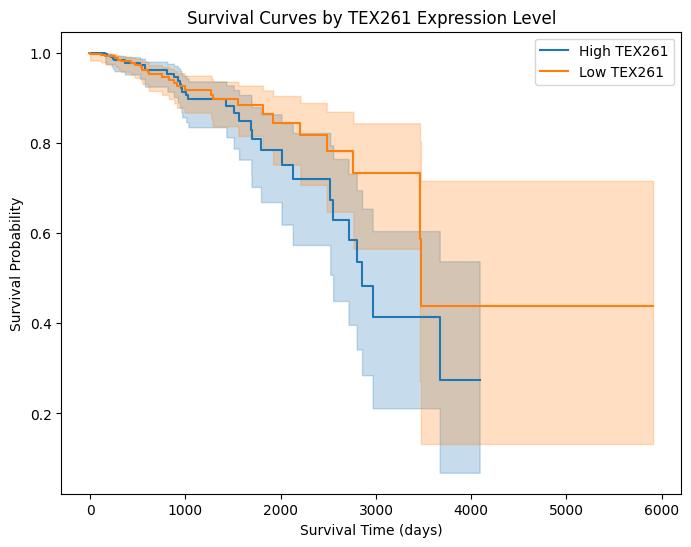

In [ ]:
# ----------------------------
# Step 12: Visualize survival curves for top DEG
# ----------------------------
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Choose top-risk DEG from the Cox model coefficients already calculated
top_DEG = cox_penalized.summary.sort_values(by='coef', ascending=False).index[0]
print("Top risk DEG for visualization:", top_DEG)

# Median split of expression
median_expr = cox_data_deg[top_DEG].median()
high_expr = cox_data_deg[cox_data_deg[top_DEG] > median_expr]
low_expr = cox_data_deg[cox_data_deg[top_DEG] <= median_expr]

# Initialize Kaplan-Meier fitters
kmf_high = KaplanMeierFitter()
kmf_low = KaplanMeierFitter()

# Fit KM curves using correct survival variable names
kmf_high.fit(
    durations=high_expr['survival_time'],
    event_observed=high_expr['event'],
    label=f'High {top_DEG}'
)

kmf_low.fit(
    durations=low_expr['survival_time'],
    event_observed=low_expr['event'],
    label=f'Low {top_DEG}'
)

# Plot survival curves
plt.figure(figsize=(8, 6))
kmf_high.plot_survival_function(ci_show=True)
kmf_low.plot_survival_function(ci_show=True)

plt.title(f"Survival Curves by {top_DEG} Expression Level")
plt.xlabel("Survival Time (days)")
plt.ylabel("Survival Probability")

plt.show()


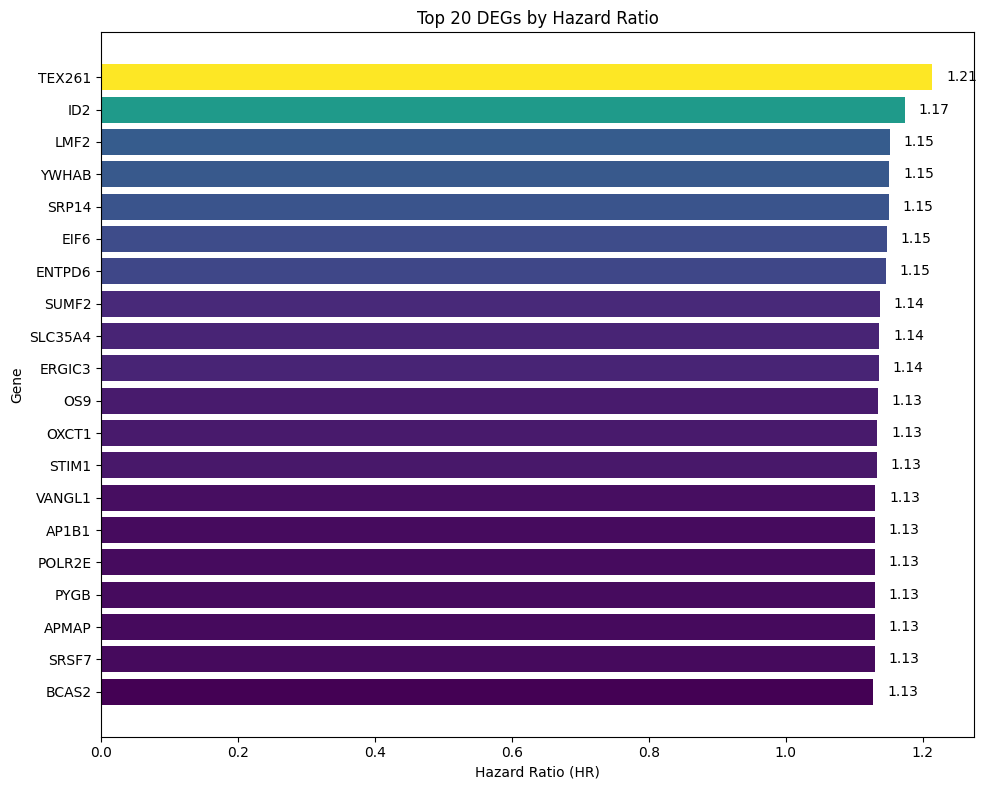

In [ ]:
# ----------------------------
# Step 13: Bar plot of top 20 DEGs' hazard ratios
# ----------------------------
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Sort genes by highest hazard coefficient
top20 = cox_penalized.summary.sort_values(by='coef', ascending=False).head(20).copy()

# Compute HR (exp(coef))
top20['HR'] = np.exp(top20['coef'])

# Normalize HR values for color map
norm = mcolors.Normalize(vmin=top20['HR'].min(), vmax=top20['HR'].max())
cmap = cm.viridis
colors = [cmap(norm(hr)) for hr in top20['HR']]

# Horizontal bar plot
plt.figure(figsize=(10, 8))
plt.barh(top20.index, top20['HR'], color=colors)
plt.xlabel('Hazard Ratio (HR)')
plt.ylabel('Gene')
plt.title('Top 20 DEGs by Hazard Ratio')

# Annotate
for i, hr in enumerate(top20['HR']):
    plt.text(hr + 0.02, i, f"{hr:.2f}", va='center')

plt.gca().invert_yaxis()  # highest HR at the top
plt.tight_layout()
plt.show()
